In [1]:
import jax

In [2]:
import jax.numpy as jnp
from jax import grad,hessian, jit, vmap

In [20]:
from multiinstance.data.realData import buildDataset as buildReal
from glob import glob

In [3]:
from jax.test_util import check_grads

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from multiinstance.data.syntheticData import buildDataset

In [7]:
from multiinstance.ward_clustering import WardClustering

In [8]:
from multiinstance.utils import *

In [9]:
import scipy.stats as ss
from tqdm.notebook import tqdm

In [10]:
def logLikelihood(alphas, mu, sigma):
    ll = jnp.sum(jax.scipy.stats.norm.logpdf(alphas,mu,sigma))
    return ll / len(alphas)

def getLevelClusters(rowNum, clusterAssignments):
    clusterLabels = jnp.unique(clusterAssignments[rowNum])
    clusters = {c : jnp.where(clusterAssignments[rowNum] == c)[0] for c in clusterLabels}
    return clusters

def getClusterMean(leafMeans, numU, clusterMembers):
    n = numU[clusterMembers]
    a = leafMeans[clusterMembers]
    return jnp.dot(a,n) * (1 / jnp.sum(n))
    
def treeNegLogLikelihood(leafMeans, clusterVars, alphaHatMat, numU, clusterAssigments, loc2Idx):
    NLL = 0
    for rowNum in range(clusterAssigments.shape[0]):
        clusters = getLevelClusters(rowNum, clusterAssigments)
        for clusterIdx, clusterMembers in clusters.items():
            clusterMean = getClusterMean(leafMeans, numU, clusterMembers)
            varIdx = loc2Idx[(rowNum, clusterIdx)]
            clusterVar = clusterVars[varIdx]
            alphaHats = alphaHatMat[rowNum, clusterIdx]
            NLL = NLL - logLikelihood(alphaHats, clusterMean, clusterVar)
    return NLL

In [11]:
def prep(alphaHatMat, clusterAssignments):
    leafMeans = jnp.mean(alphaHatMat[0],axis=1)
    clusterVars = []
    loc2Idx = {}
    for rowNum in range(clusterAssignments.shape[0]):
        levelClusters = jnp.unique(clusterAssignments[rowNum])
        for cluster in levelClusters:
            loc2Idx[(rowNum,cluster)] = len(clusterVars)
            alphaHats = alphaHatMat[rowNum, cluster]
            _,v = ss.norm.fit(alphaHats)
            clusterVars.append(v)
    clusterVars = jnp.array(clusterVars)
    return leafMeans, clusterVars, loc2Idx

In [12]:
def run(ds, clusterAssignments, alphaHatMat, NIterations=100, lr=0.01):
    
    leafMeans, clusterVars, loc2Idx = prep(alphaHatMat, clusterAssignments)
    meanHistory = [leafMeans]
    scaleHistory = [clusterVars]
    maes = [jnp.mean(jnp.abs(ds.trueAlphas.flatten() - leafMeans))]
    numU = jnp.array(ds.numU)
    # Define gradient and hessian
#     check_grads(treeNegLogLikelihood, (leafMeans, clusterVars, 
#                                        alphaHatMat, numU,
#                                        clusterAssignments, loc2Idx),order=1)
    meanVarGrad = grad(treeNegLogLikelihood,argnums=(0,1))
    meanHessian = jax.jacfwd(jax.jacrev(lambda m,v: treeNegLogLikelihood(m, v, alphaHatMat, numU, clusterAssignments, loc2Idx)))
    varHessian = jax.jacfwd(jax.jacrev(lambda v,m: treeNegLogLikelihood(m, v, alphaHatMat, numU, clusterAssignments, loc2Idx)))
    meanVarHessian = grad(grad(treeNegLogLikelihood,argnums=(0,1)), argnums=(0,1))
    # Run Iterations
    for iteration in tqdm(range(NIterations),total=NIterations):
        meanGrad, varGrad = meanVarGrad(leafMeans, clusterVars, alphaHatMat, numU, clusterAssignments, loc2Idx)
        leafMeans = leafMeans - lr * jnp.linalg.inv(meanHessian(leafMeans, clusterVars)) @ meanGrad
        clusterVars = clusterVars - lr * jnp.linalg.inv(varHessian(clusterVars, leafMeans)) @ varGrad
        #leafMeans = leafMeans - lr * meanGrad
        #clusterVars = clusterVars - lr * varGrad
        meanHistory.append(leafMeans)
        scaleHistory.append(clusterVars)
        maes.append(jnp.mean(jnp.abs(ds.trueAlphas.flatten() - leafMeans)))
    return leafMeans, clusterVars, loc2Idx, meanHistory, scaleHistory, maes

In [13]:
def plotDistrTree(trueAlphas, alphaHatMat, meanHistory, scaleHistory,loc2Index,clusterAssignments, numU):
    rows,cols = list(zip(*list(loc2Idx.keys())))
    Nrows = np.max(rows) + 1
    Ncols = np.max(cols) + 1
    fig,ax = plt.subplots(nrows=Nrows,ncols=Ncols, figsize=(5 * Nrows, 5*Ncols))
    for row in range(clusterAssignments.shape[0]):
        clusters = np.unique(clusterAssignments[row])
        for c in clusters:
            scale = scaleHistory[-1][loc2Index[(row,c)]]
            scale0 = scaleHistory[0][loc2Index[(row,c)]]
            children = np.where(clusterAssignments[row] == c)[0]
            childMeans = meanHistory[-1][children]
            childMeans0 = meanHistory[0][children]
            childN = numU[children]
            mu = np.dot(childMeans, childN) / childN.sum()
            mu0 = np.dot(childMeans0, childN) / childN.sum()
            alpha = np.dot(trueAlphas[children], childN)/ childN.sum()
            ax[row,c].plot(np.arange(0,1,.01),
                           ss.norm.pdf(np.arange(0,1,.01),loc=mu,scale=scale),color="green")
            ax[row,c].plot(np.arange(0,1,.01),
                           ss.norm.pdf(np.arange(0,1,.01),loc=mu0,scale=scale0),color="red",alpha=.5)
            ax[row,c].hist(alphaHatMat[row,c],density=True,color="blue")
            ax[row,c].vlines(alpha, 0,1,color="red")
    plt.show()
    return fig

In [14]:
ds = buildDataset(1,alphaDistr=lambda: np.random.choice([.2]),
                  nP=100,nU=200,posMean=5,negMean=1,cov=1)
ds2 = buildDataset(1,alphaDistr=lambda: np.random.choice([.8]),
                  nP=100,nU=200,posMean=5,negMean=1,cov=1)
ds.merge(ds2)
ds = addTransformScores(ds)
ds.alphaHats,ds.curves = getBagAlphaHats(ds,numbootstraps=50)

In [15]:
ward = WardClustering(ds,numbootstraps=ds.alphaHats.shape[1],randomPairing=True)

In [16]:
ward.cluster()

In [17]:
leafMeans, clusterVars, loc2Idx,meanHistory, scaleHistory,maes = run(ds,ward.clusterAssignment.astype(int),
                                                                     ward.alphaHatMat,lr=0.01,NIterations=250)

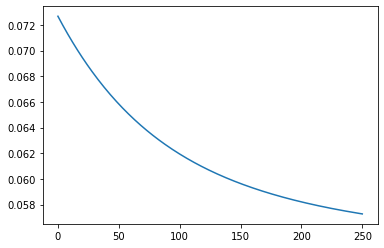

In [18]:
plt.plot(maes)

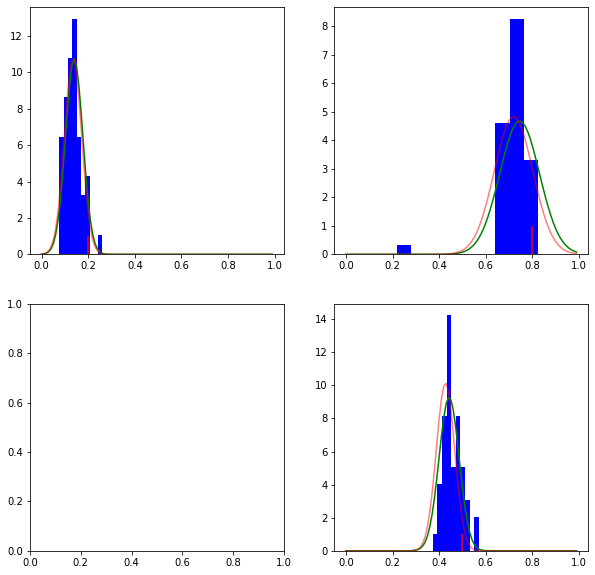

In [19]:
fig = plotDistrTree(ds.trueAlphas.flatten(),
              ward.alphaHatMat, meanHistory,
              scaleHistory, loc2Idx,
              ward.clusterAssignment.astype(int), ds.numU)

In [22]:
from sklearn.metrics import roc_auc_score
def posteriorCorrection(tau, alpha, S0S1):
    post =  alpha * S0S1 * (tau / (1 - tau))
    post[np.isinf(post)] = 1
    return post

def correctedAUC(ds,bagAlphaHats,):
    _, tauArrays = list(zip(*[getTransformScores(ds,i) for i in range(ds.N)]))
    S0_S1 = ds.numU/ds.numP
    posteriors = [posteriorCorrection(tau,alphaHat, s0s1) for tau,alphaHat,s0s1 in zip(tauArrays,
                                                                                       bagAlphaHats,
                                                                                       S0_S1)]
    posteriorVals = np.concatenate(posteriors)
    hiddenLabels = np.concatenate([ds.hiddenLabels[i][:ds.numU[i]] for i in range(ds.N)])
    return roc_auc_score(hiddenLabels, posteriorVals)

In [ ]:
absErrs = {"local":[],
           "random":[],
           "ward":[],
           "global": []}

aucVals = {"local":[],
           "random":[],
           "ward":[],
           "global": []}
N = 0
for f in tqdm(glob("/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/*.mat")[1:]):
    dsi = buildReal(f,16,
                    alphaDistr=lambda: np.random.uniform(.25,.75),
                    nPDistr=lambda: 1 + np.random.poisson(125),
                    nUDistr=lambda: 1 + np.random.poisson(175))
    dsi = addTransformScores(dsi)
    dsi = addGlobalEsts(dsi,reps=10)
    dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,
                                               numbootstraps=100)
    globalMAE = np.mean(np.abs(dsi.trueAlphas.flatten() - dsi.globalAlphaHats.mean()))
    absErrs["global"].append(globalMAE * dsi.N)
    aucVals["local"].append(correctedAUC(dsi,dsi.alphaHats.mean(1)))
    aucVals["global"].append(correctedAUC(dsi,np.ones(dsi.N)*dsi.globalAlphaHats.mean()))
    # Ward Clustering
    wrd = WardClustering(dsi,numbootstraps=dsi.alphaHats.shape[1],randomPairing=False)
    wrd.cluster()
    leafMeans, clusterVars, loc2Idx,meanHistory, scaleHistory,maes = run(dsi,wrd.clusterAssignment.astype(int),
                                                                     wrd.alphaHatMat,lr=0.01, NIterations=100)
    absErrs["local"].append(maes[0] * dsi.N)
    absErrs["ward"].append(maes[-1] * dsi.N)
    aucVals["ward"].append(correctedAUC(dsi, leafMeans))
    # Random Clustering
    wrd2 = WardClustering(dsi,numbootstraps=dsi.alphaHats.shape[1],randomPairing=True)
    wrd2.cluster()
    leafMeans2, clusterVars2, loc2Idx2,meanHistory2, scaleHistory2,maes2 = run(dsi,
                                                                               wrd2.clusterAssignment.astype(int),
                                                                               wrd2.alphaHatMat,
                                                                               lr=0.01, NIterations=100)
    absErrs["random"].append(maes2[-1] * dsi.N)
    aucVals["random"].append(correctedAUC(dsi, leafMeans2))
    maefig,ax = plt.subplots()
    ax.plot(maes,label="ward")
    ax.plot(maes2,label="random")
    ax.hlines(globalMAE,0,len(maes),label="global")
    ax.legend()
    plt.show()
#     treeFig = plotDistrTree(dsi.trueAlphas.flatten(),
#                         wrd.alphaHatMat,
#                         meanHistory,
#                         scaleHistory,
#                         loc2Idx,
#                         wrd.clusterAssignment.astype(int),
#                         dsi.numU)
#     fig,ax = plt.subplots()
#     plt.plot(mth.NLLs)
#     plt.show()
    N += dsi.N
    print("MAE")
    print("local: {:.3f}".format(np.sum(absErrs["local"])/N))
    print("ward: {:.3f}".format(np.sum(absErrs["ward"])/N))
    print("random: {:.3f}".format(np.sum(absErrs["random"])/N))
    print("global: {:.3f}".format(np.sum(absErrs["global"])/N))
    print("AUC")
    print("local: {:.3f}".format(np.mean(aucVals["local"])))
    print("ward: {:.3f}".format(np.mean(aucVals["ward"])))
    print("random: {:.3f}".format(np.mean(aucVals["random"])))
    print("global: {:.3f}".format(np.mean(aucVals["global"])))

/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
wrd.cl

In [ ]:
(wrd.alphaHatMat == 0).all(2)

In [ ]:
(wrd.alphaHatMat[1] == 0).all(1)

In [ ]:
wrd.clusterAssignment